# What Makes A Best Original Screenplay?

    By Allison Ragan and Allison Shafer
    American University
    STAT-696 Applied Natural Language Processing

# Analysis

# Table of Contents

    I. Package Imports
    II. NLP Transformations
        i. CountVectorized
        ii. TFIDF
    III. Sentiment Analysis
        i. Sentiment Analysis -- Dialogue
        ii. Sentiment Analysis -- Full Script
    IV. Topic Modeling
        i. Topic Modeling -- Dialogue
        ii. Topic Modeling -- Full Script
    V. K-Means Clustering
        i. K-Means Clustering -- Dialogue
        ii. K-Means Clustering -- Full Script
    VI. Results

## Package Imports

In [1]:
import pandas as pd 
import numpy as np
import re
import nltk
import os 
from nltk import word_tokenize
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import NMF as nmf
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import wordcloud
#!pip install wordcloud
from plotnine import *
#!pip install plotnine
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from sklearn.manifold import TSNE
from afinn import Afinn
#!pip install afinn

In [2]:
# Read in .csv to dataframe
movies_df = pd.read_csv('./movies_df.csv')

# modify titles for viz
prettytitle = ['First Reformed', 'Green Book', 'Hell or HighWater', 'Lady Bird', 'LaLa Land', 'Marriage Story', 
               'Roma', 'The Shape of Water', 'The Big Sick', 'The Favourite', 'Three Billboards', 'Vice', '1917', 
               '20th Century Women', 'Bridge of Spies', 'Ex Machina', 'Get Out', 'Inside Out', 'Knives Out', 
               'Manchester by the Sea', 'Parasite', 'Spotlight', 'Straight Outta Compton', 'The Lobster']
movies_df['Title'] = prettytitle

movies_df.head()

,Unnamed: 0,Title,Script,year,orig_screen_win,best_pic_win,reviewer,cleaned_dialogue,cleaned_script,script_length,dialogue_length,Genres,GenresBroad,Rating,Critic_Score,Aud_Score,RunTime
0,0,First Reformed,Scripts.com\n\nFirst Reformed\n\nBy Paul Schra...,2018,0,NaN,Ragan,keep journal word program digital file longhan...,bird calling distance toller keep journal word...,4016,3966,Drama,Drama,R,93,68,108
1,1,Green Book,GREEN BOOK \n\nWritten by \n\nNick Vallelonga ...,2018,1,Win,Ragan,thank much welcome jules podell copacabana bob...,fade title card new york city 1962 ext copacab...,12048,7363,Drama,Drama,PG-13,78,91,130
2,2,Hell or HighWater,Scripts.com\n\nHell or High Water\n\nBy Taylor...,2016,0,Nom,Ragan,quiet open door open door devil please stand t...,quiet open door open door devil please stand t...,3371,3371,Drama,Mystery Suspense,R,97,88,102
3,3,Lady Bird,\n \n\n \n \n \n \n \n \n \n \n \n \n \n \n \...,2017,0,Nom,Ragan,making bed looking back loan scholarship world...,anybody talk california hedonism never spent c...,9654,5916,Comedy-Drama,Comedy-Drama,R,99,79,93
4,4,LaLa Land,LA LA LAND\n\nby\n\nDamien Chazelle\n\n A sun-...,2016,0,Nom,Ragan,think going worst working like gon talk talk w...,sunblasted sky hear radio one piece music anot...,9537,6634,Comedy-Drama,Comedy-Drama,PG-13,91,81,128


## Data Visualizations Setup

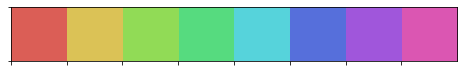

In [3]:
# set color scheme
pal = sns.color_palette("hls", 8)
palette_list = pal.as_hex()
sns.palplot(sns.color_palette("hls", 8))

## Prep Data for Analysis


In [4]:
# Created grouped data
Genres_df = movies_df.groupby(["GenresBroad"])
Win_Lose = movies_df.groupby('orig_screen_win')

# sanity check on grouping
Genres_df.agg({'dialogue_length':sum})
Win_Lose.agg({'dialogue_length':sum})

# Group text by Genre for analysis
text_group_genre = Genres_df['cleaned_dialogue'].apply(' '.join).reset_index()
text_group_genre = pd.DataFrame(text_group_genre)

# Group text by winner/loser for analysis
win_lose_text = Win_Lose['cleaned_dialogue'].apply(' '.join).reset_index()

## NLP transformations

### CV

In [5]:
# all scripts and visuals 
bow_all = CountVectorizer(ngram_range=(1,2), max_df = .85, min_df = .2)
# fit + transform training data
bow_all_fit = bow_all.fit_transform(movies_df['cleaned_script'])

# for dialogue only
bow_dialogue = CountVectorizer(ngram_range=(1,2), max_df = .85, min_df = .2)
# fit + transform training data
bow_dialogue_fit = bow_dialogue.fit_transform(movies_df['cleaned_dialogue'])

### TFIDF

In [6]:
# instantiate - All parts of script
tfidf_all = TfidfVectorizer(ngram_range = (1,2), max_df = .8, min_df = .2, stop_words = 'english')
# fit + transform training data - all scripts and visuals
tfidf_all_fit = tfidf_all.fit_transform(movies_df['cleaned_script'])
tfidf_vocab_all = tfidf_all.vocabulary_
tfidf_vocab_all = {k: v for k, v in sorted(tfidf_vocab_all.items(), key=lambda item: item[1], reverse=True)}
# print(tfidf_vocab_all)
# len(tfidf_vocab_all)

# instantiate - Dialogue Only
tfidf_dialogue = TfidfVectorizer(ngram_range = (1,2), max_df = .85, min_df = .2, stop_words = 'english')
# fit + transform training data - dialogue only 
tfidf_dialogue_fit = tfidf_dialogue.fit_transform(movies_df['cleaned_dialogue'])
tfidf_vocab_dialogue = tfidf_dialogue.vocabulary_
tfidf_vocab_dialogue = {k: v for k, v in sorted(tfidf_vocab_dialogue.items(), key=lambda item: item[1], reverse=True)}
# print(tfidf_vocab_dialogue)
# len(tfidf_vocab_dialogue)

# Sentiment Analysis

Using AFINN lexicon, aka the "new ANEW" which calculates a polarity score associated with each word.


### Sentiment Analysis -- Dialogue

In [7]:
# initialize afinn sentiment analyzer
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in list(movies_df['cleaned_dialogue'])]
sentiment_category = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in sentiment_scores]

afinn_dialogue = pd.DataFrame([list(movies_df['Title']), list(movies_df['GenresBroad']), list(movies_df['orig_screen_win']), sentiment_scores, sentiment_category]).T
afinn_dialogue.columns = ['Titles', 'Genres', 'Winner', 'SentimentScore', 'SentimentCategory']
afinn_dialogue['SentimentScore'] = afinn_dialogue['SentimentScore'].astype('float')

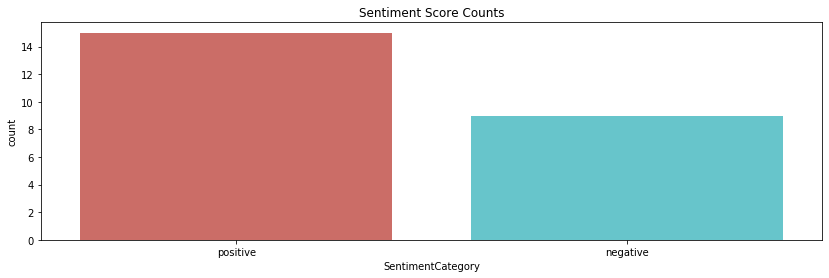

In [8]:
plt.figure(figsize=(14,4))
sns.countplot(x='SentimentCategory', data=afinn_dialogue, palette="hls").set_title("Sentiment Score Counts")
plt.show()

#### Winners vs Nominees

In [9]:
# sentiment statistics for winners/losers
afinn_dialogue.groupby(by = ['Winner']).describe()

SentimentScore                                                       \
                count        mean         std     min    25%    50%    75%   
Winner                                                                       
0                19.0   43.157895  496.743536 -1120.0 -199.0  141.0  359.5   
1                 5.0  105.400000  139.890314   -32.0    9.0   75.0  153.0   

               
          max  
Winner         
0       932.0  
1       322.0

Text(0.5, 1.0, 'Count Plot of Sentiment Score by Result')

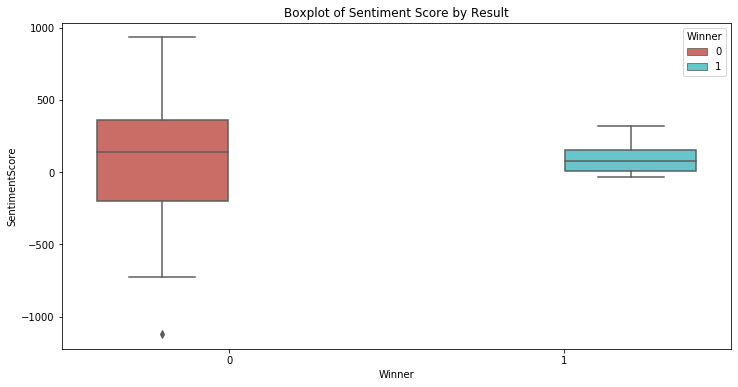

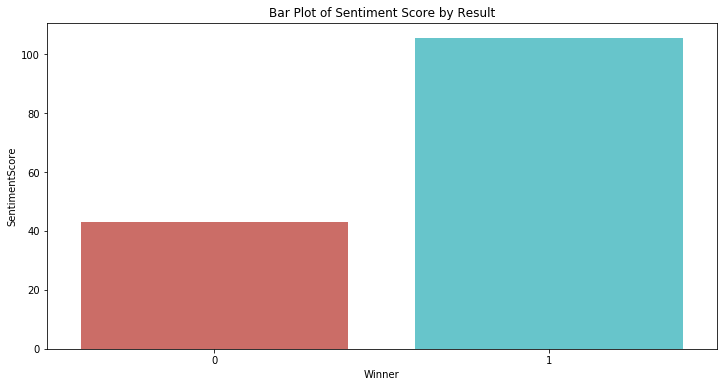

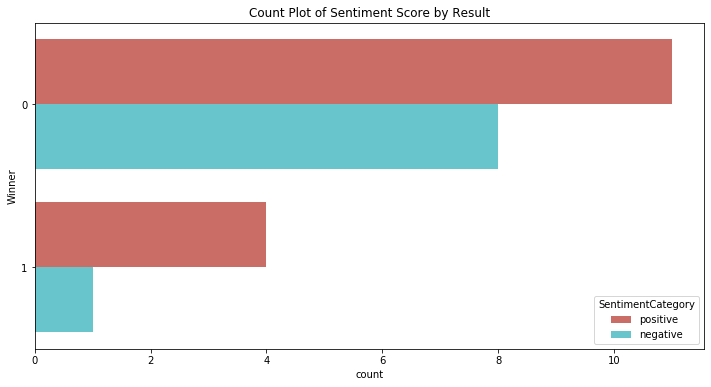

In [10]:
# boxplot
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.boxplot(x = 'Winner', y = "SentimentScore", 
                 hue = 'Winner', data = afinn_dialogue, ax = ax,
                 palette = "hls").set_title('Boxplot of Sentiment Score by Result')

# barplot
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.barplot(x = "Winner", y = "SentimentScore", ax = ax, data = afinn_dialogue, 
            palette = "hls", ci = None).set_title('Bar Plot of Sentiment Score by Result')

# countplot
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.countplot(y = "Winner", hue = "SentimentCategory", data = afinn_dialogue, 
              ax = ax, palette = "hls").set_title('Count Plot of Sentiment Score by Result')

#### Genres

In [11]:
# sentiment statistics for winners/losers
afinn_dialogue.groupby(by = ['Genres']).describe()

SentimentScore                                          \
                          count        mean         std     min     25%   
Genres                                                                    
Animation                   1.0  932.000000         NaN   932.0  932.00   
Comedy                      1.0  352.000000         NaN   352.0  352.00   
Comedy-Drama                5.0   50.000000  666.596205 -1120.0  151.00   
Drama                      11.0   15.909091  415.693025  -723.0 -237.50   
Mystery Suspense            6.0  -60.333333  123.065294  -246.0 -125.25   

                                        
                    50%     75%    max  
Genres                                  
Animation         932.0  932.00  932.0  
Comedy            352.0  352.00  352.0  
Comedy-Drama      300.0  445.00  474.0  
Drama             141.0  237.50  681.0  
Mystery Suspense  -38.5   -1.25  104.0

Text(0.5, 1.0, 'Count Plot of Sentiment Score by Genre')

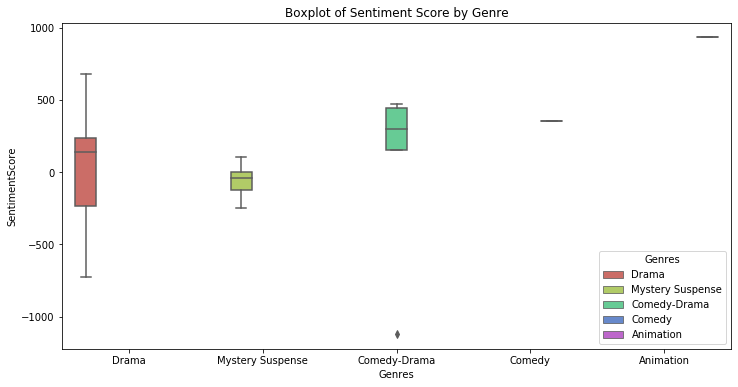

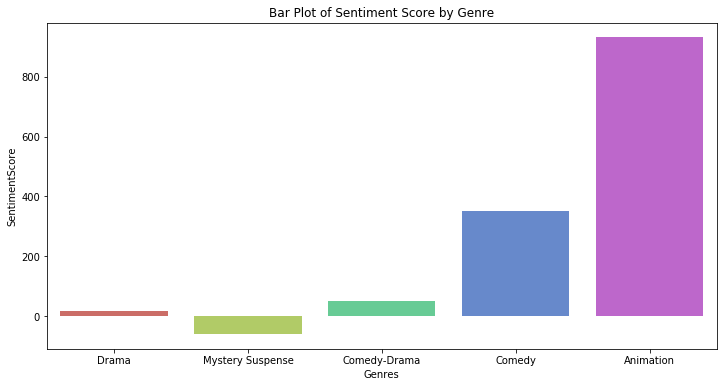

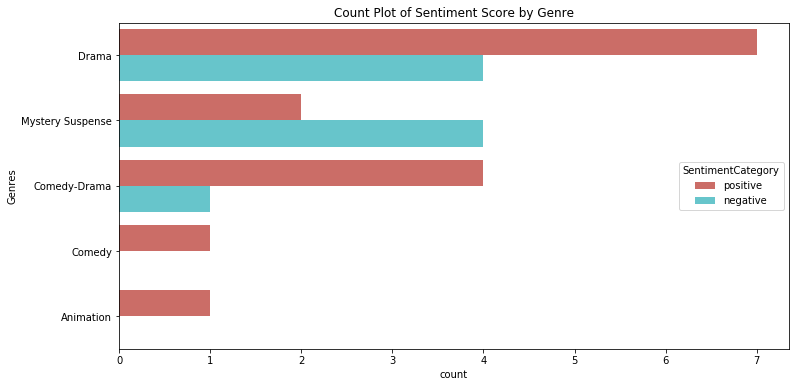

In [12]:
# boxplot
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.boxplot(x = 'Genres', y = "SentimentScore", 
                 hue = 'Genres', data = afinn_dialogue, ax = ax,
                 palette = "hls").set_title('Boxplot of Sentiment Score by Genre')

# barplot
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.barplot(x = "Genres", y = "SentimentScore", ax = ax, data = afinn_dialogue, 
            palette = "hls", ci = None).set_title('Bar Plot of Sentiment Score by Genre')

# countplot
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y = "Genres", hue = "SentimentCategory", data = afinn_dialogue, 
              ax = ax, palette = "hls").set_title('Count Plot of Sentiment Score by Genre')

### Sentiment Analysis -- Full Script

In [13]:
# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in list(movies_df['cleaned_script'])]
sentiment_category = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in sentiment_scores]

afinn_all = pd.DataFrame([list(movies_df['Title']), list(movies_df['GenresBroad']), list(movies_df['orig_screen_win']), sentiment_scores, sentiment_category]).T
afinn_all.columns = ['Titles', 'Genres', 'Winner', 'SentimentScore', 'SentimentCategory']
afinn_all['SentimentScore'] = afinn_all['SentimentScore'].astype('float')

#### Winners vs Nominees

In [14]:
# sentiment statistics for winners/losers
afinn_dialogue.groupby(by=['Winner']).describe()

SentimentScore                                                       \
                count        mean         std     min    25%    50%    75%   
Winner                                                                       
0                19.0   43.157895  496.743536 -1120.0 -199.0  141.0  359.5   
1                 5.0  105.400000  139.890314   -32.0    9.0   75.0  153.0   

               
          max  
Winner         
0       932.0  
1       322.0

Text(0.5, 1.0, 'Count Plot of Sentiment Category by Result')

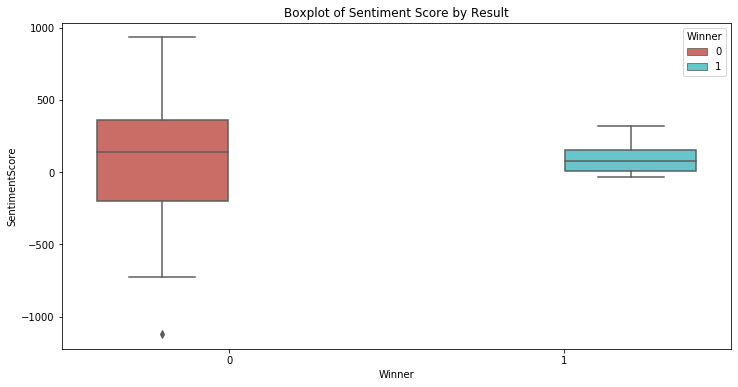

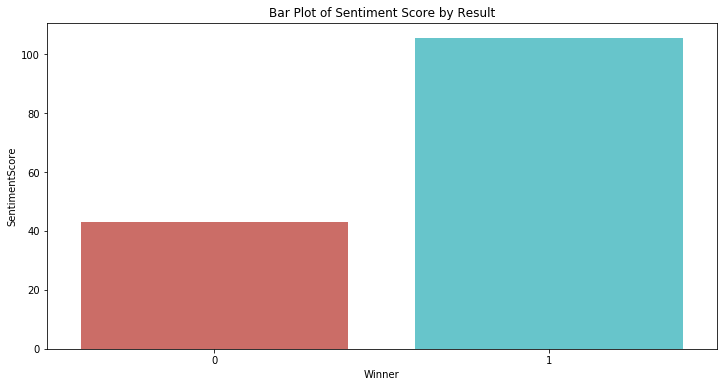

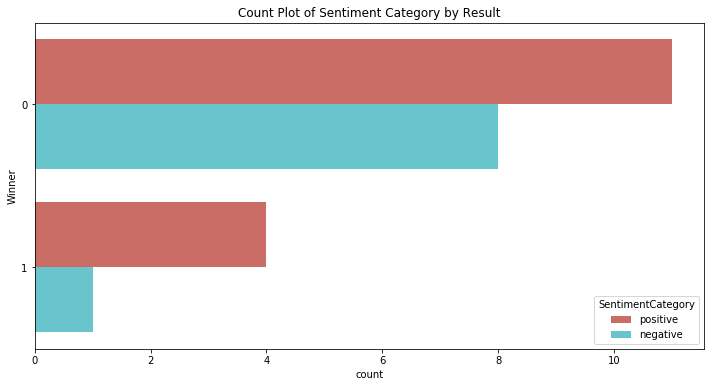

In [15]:
# boxplot
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.boxplot(x = 'Winner', y = "SentimentScore", 
                 hue = 'Winner', data = afinn_dialogue, ax = ax,
                 palette = "hls").set_title('Boxplot of Sentiment Score by Result')

# barplot
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.barplot(x = "Winner", y = "SentimentScore", ax = ax, data = afinn_dialogue, 
            palette = "hls", ci = None).set_title('Bar Plot of Sentiment Score by Result')

# countplot
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.countplot(y = "Winner", hue = "SentimentCategory", data = afinn_dialogue, 
              ax = ax, palette = "hls").set_title('Count Plot of Sentiment Category by Result')


#### Genre

In [16]:
# sentiment statistics for winners/losers
afinn_all.groupby(by=['Genres']).describe()

SentimentScore                                            \
                          count         mean         std     min      25%   
Genres                                                                      
Animation                   1.0  1271.000000         NaN  1271.0  1271.00   
Comedy                      1.0   343.000000         NaN   343.0   343.00   
Comedy-Drama                5.0     8.800000  697.012338 -1193.0    35.00   
Drama                      11.0   -96.818182  601.978873 -1432.0  -326.00   
Mystery Suspense            6.0    22.500000  214.712599  -246.0  -160.75   

                                          
                     50%     75%     max  
Genres                                    
Animation         1271.0  1271.0  1271.0  
Comedy             343.0   343.0   343.0  
Comedy-Drama       244.0   459.0   499.0  
Drama               76.0   245.0   711.0  
Mystery Suspense    93.0   154.0   266.0

Text(0.5, 1.0, 'Count Plot of Sentiment Score by GenreBroad')

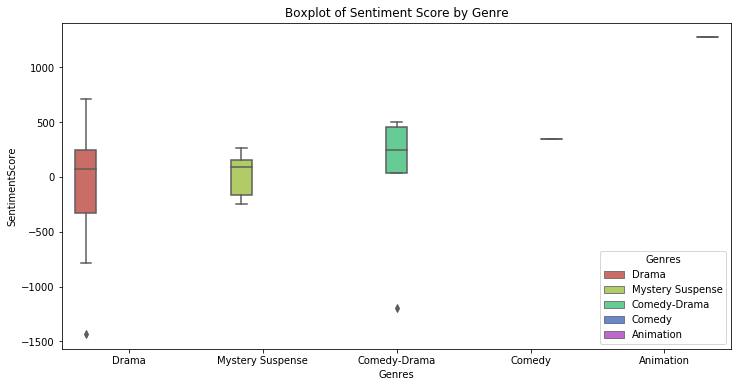

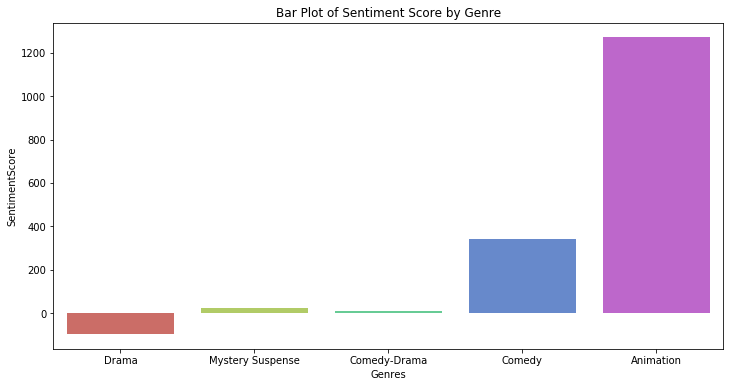

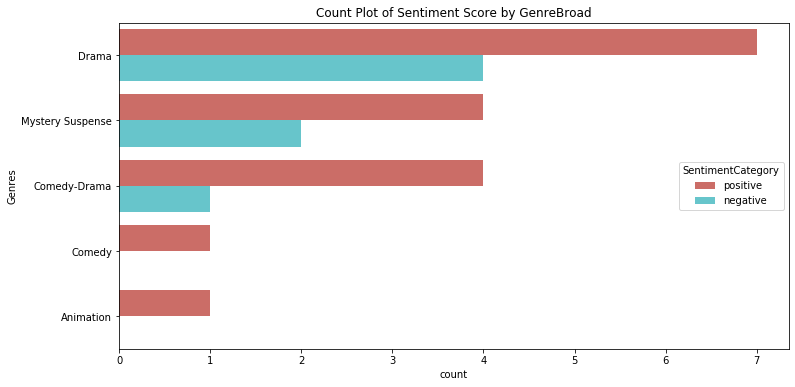

In [17]:
# boxplot
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.boxplot(x = 'Genres', y = "SentimentScore", 
                 hue = 'Genres', data = afinn_all, ax = ax,
                 palette = "hls").set_title('Boxplot of Sentiment Score by Genre')

# barplot
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "Genres", y = "SentimentScore", ax = ax, data = afinn_all, 
            palette = "hls", ci = None).set_title('Bar Plot of Sentiment Score by Genre')

# countplot
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y = "Genres", hue = "SentimentCategory", data = afinn_all, 
              ax = ax, palette = "hls").set_title('Count Plot of Sentiment Score by GenreBroad')

### Sentiment Analysis Over Time

In [18]:
# split script into chunks of 50 words
# stitch together new data frame by hand
title = list(movies_df['Title'])
script = list(movies_df['cleaned_script'])
orig_screen_win = list(movies_df['orig_screen_win'])
genre = list(movies_df['GenresBroad'])

# tokenize scripts_lengths
scripts_tokenized = [word_tokenize(s) for s in script]

# write function to chunk scripts
def chunk_scripts(script, n=250):
    # loop until length == 1
    for i in range(0, len(script), n):
        yield script[i:i + n]

# chunk scripts into 250 words
script_chunks = [list(chunk_scripts(s)) for s in scripts_tokenized]

# record number of chunks for each script
chunk_lengths = [len(script_chunks[sc]) for sc in range(len(script_chunks))]

# create list of indices
chunk_idx = [list(range(0, c)) for c in chunk_lengths]

# adjust other columns accordingly
title_chunk = [[title[cl]]*chunk_lengths[cl] for cl in range(len(chunk_lengths))]
win_chunk = [[orig_screen_win[cl]]*chunk_lengths[cl] for cl in range(len(chunk_lengths))]
genre_chunk = [[genre[cl]]*chunk_lengths[cl] for cl in range(len(chunk_lengths))]

# flatten
chunk_id = [item for sublist in chunk_idx for item in sublist]
title = [item for sublist in title_chunk for item in sublist]
win = [item for sublist in win_chunk for item in sublist]
genre = [item for sublist in genre_chunk for item in sublist]

# sanity check
print(len(title)  == len(win) == len(genre) == len(chunk_id) == sum(chunk_lengths))

# return script to a string
for s in range(len(script_chunks)):
    for sc in range(len(script_chunks[s])):
        script_chunks[s][sc] = " ".join(script_chunks[s][sc])

# flatten
scripts = [item for sublist in script_chunks for item in sublist]

# sanity check
print(len(title)  == len(win) == len(genre) == len(chunk_id) == sum(chunk_lengths) == len(scripts))

# construct data frame from lists
list_dict = {"Title": title, "Chunk": chunk_id, "Winner": win, "Genre": genre, "Script": scripts}
chunked_df = pd.DataFrame(list_dict)

True
True


Text(0.5, 1.0, 'Sentiment Over Time by Film')

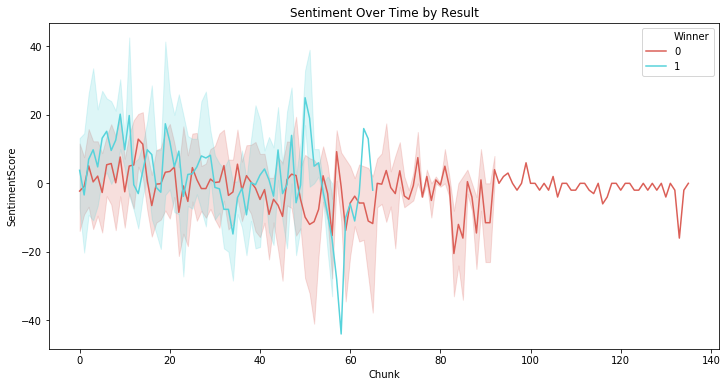

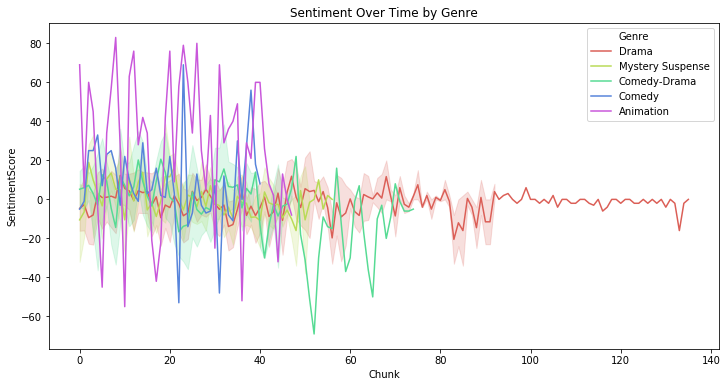

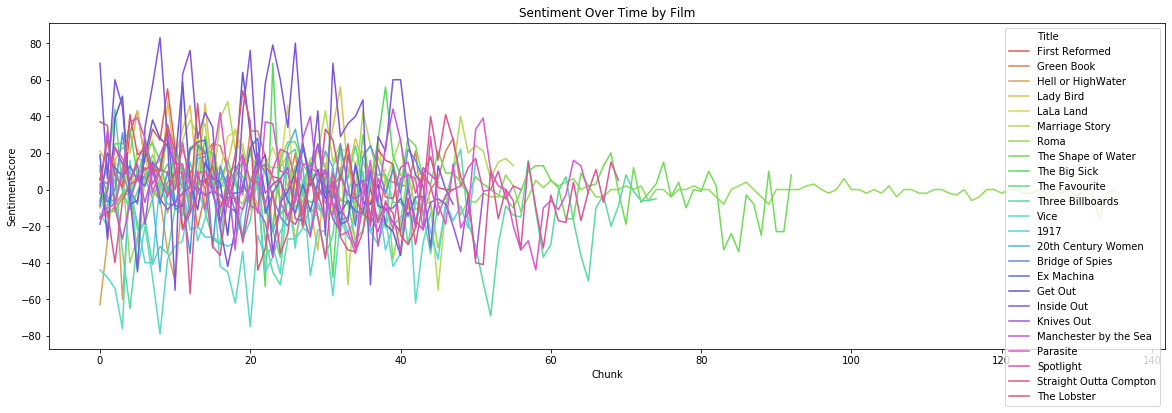

In [19]:
# initialize afinn sentiment analyzer
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in list(chunked_df['Script'])]
sentiment_category = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in sentiment_scores]

afinn_over_time = pd.DataFrame([list(chunked_df['Title']), list(chunked_df['Chunk']), list(chunked_df['Winner']), list(chunked_df['Genre']), sentiment_scores, sentiment_category]).T
afinn_over_time.columns = ['Title', 'Chunk', 'Winner', 'Genre', 'SentimentScore', 'SentimentCategory']
afinn_over_time['SentimentScore'] = afinn_over_time['SentimentScore'].astype('float')

# sentiment over time by winner
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.lineplot(x = 'Chunk', y = "SentimentScore", 
                 hue = 'Winner', data = afinn_over_time, ax = ax,
                 palette = "hls").set_title('Sentiment Over Time by Result')

# sentiment over time by genre
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.lineplot(x = 'Chunk', y = "SentimentScore", 
                 hue = 'Genre', data = afinn_over_time, ax = ax,
                 palette = "hls").set_title('Sentiment Over Time by Genre')

# sentiment over time by title
fig_dims = (20, 6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.lineplot(x = 'Chunk', y = "SentimentScore", 
                 hue = 'Title', data = afinn_over_time, ax = ax,
                 palette = "hls").set_title('Sentiment Over Time by Film')

## Topic Modeling -- AS

### TFIDF/ NMF

### Topic Modeling -- Dialogue

In [20]:
n_dialogue = nmf(n_components = 10).fit(tfidf_dialogue_fit) # set up nmf model for 10 topics

# Dataframes for topics
def get_topics(model, vectorizer, num_topics, n_top_words):
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-15 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

get_topics(n_dialogue, tfidf_dialogue, 10, 15)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,beat,dont,gon,dick,lady,charlie,los,rose,joy,lip
1,sir,youre,fucking,power,bird,new york,sofa,rod,sadness,piano
2,nod,thats,bank,president,mom,york,patio,picture,memory,christmas
3,sign,shes,fuck,mary,dad,theater,doctor,brooklyn,island,glance
4,pie,david,beth,mike,suddenly,mom,hall,driver,dad,record
5,egg,didnt,god,agent,nod,fucking,pie,dont,thats,gon
6,blood,whats,wan,war,shall,lawyer,van,lawn,dont,george
7,grab,doesnt,cube,american,horse,hesitates,dice,dining,fear,hell
8,german,dont know,pause,office,rabbit,pause,child,richard,mom,stage
9,corridor,ill,cop,state,dress,envelope,nurse,jim,train,letter


### Topic Modeling -- Full Script

In [21]:
n_tf_all = nmf(n_components = 10).fit(tfidf_all_fit) # set up nmf model for 10 topics
get_topics(n_tf_all, tfidf_all, 10, 15)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,contd,cont,charlie,gon,lip,david,lady,joy,mike,beth
1,dont,apartment,james,bank,continued,dick,bird,sadness,priest,mary
2,youre,richard,continuous,cube,sofa,bush,cont,memory,boston,contd
3,thats,script,police station,michael,los,hotel,mom,fear,joe,cont
4,william,pie,police,leaning,cont,president,script,anger,dont,gon
5,power,party,fucking,mary,patio,waiter,shooting,mom,thats,parent
6,shes,shooting,pause,church,tony,george,sister,dad,jim,nurse
7,doesnt,corridor,int police,brother,george,manager,college,island,church,continuous
8,rose,library,road,branch,doctor,mary,dad,contd,law,doctor
9,didnt,sir,cop,sigh,italian,wood,dress,san,george,fucking


In [22]:
# Add Topics to dataframe # by dialogue
topic_values = n_dialogue.transform(tfidf_dialogue_fit)
movies_df['Dia_Topic'] = topic_values.argmax(axis = 1)

# Add Topics to dataframe # by full script
topic_values = n_tf_all.transform(tfidf_all_fit)
movies_df['Full_Topic'] = topic_values.argmax(axis = 1)

## Topic Modeling by Genre

In [23]:
# instantiate TFIDF for dialogue by genre 
tfidf_genre = TfidfVectorizer(ngram_range = (1,2), max_df = .85, min_df = 3, stop_words = 'english')

# fit + transform training data - dialogue by genre 
tfidf_genre_fit = tfidf_genre.fit_transform(text_group_genre['cleaned_dialogue'])
tfidf_vocab_genre = tfidf_genre.vocabulary_
tfidf_vocab_genre = {k: v for k, v in sorted(tfidf_vocab_genre.items(), key=lambda item: item[1], reverse=True)}
#print(tfidf_vocab_genre)

tf_genre_feat = tfidf_genre.get_feature_names()
#len(tf_genre_feat)

n_genres = nmf(n_components = 5).fit(tfidf_genre_fit) # set up nmf model for 10 topics - one for each movie?
get_topics(n_genres, tfidf_genre, 5, 20)
gen_titles = ['Animation', 'Comedy', 'Comedy-Drama', 'Drama', 'Mystery-Susp.']

text_group_genre

,GenresBroad,cleaned_dialogue
0,Animation,ever look someone wonder going inside head wel...
1,Comedy,bob dalaban true cokehead gon say anything yea...
2,Comedy-Drama,making bed looking back loan scholarship world...
3,Drama,keep journal word program digital file longhan...
4,Mystery Suspense,quiet open door open door devil please stand t...


## Topic Modeling Amongst Winners

In [24]:
# create dataframe of only winning or only losing scripts
winners = movies_df[movies_df['orig_screen_win'] == 1].copy()
losers = movies_df[movies_df['orig_screen_win'] == 0].copy()

In [25]:
# instantiate TFIDF for dialogue for winners
tfidf_winners = TfidfVectorizer(ngram_range = (1,2), max_df = .85, min_df = 3, stop_words = 'english')

# fit + transform training data - dialogue for winning scripts
tfidf_winners_fit = tfidf_winners.fit_transform(winners['cleaned_dialogue'])
tfidf_vocab_winners = tfidf_winners.vocabulary_
tfidf_vocab_winners = {k: v for k, v in sorted(tfidf_vocab_winners.items(), key=lambda item: item[1], reverse=True)}
#print(tfidf_vocab_winners)
#len(tfidf_vocab_winners)

tf_winners_feat = tfidf_winners.get_feature_names()
n_winners = nmf(n_components = 5).fit(tfidf_winners_fit) # set up nmf model for 10 topics - one for each movie?
get_topics(n_winners, tfidf_winners, 5, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,dont,lip,contd,boston,dont
1,gon,gon,picture,story,park
2,thats,christmas,chair,desk,youre
3,wan,glance,brooklyn,contd,thats
4,joe,hell,walter,jim,stair
5,uncle,black,black,dont,shes
6,george,people,begin,cut,people
7,youre,letter,fall,said,yes
8,yes,beat,dont,reading,laugh
9,dad,yes,american,case,didnt


In [26]:
# create topic field for winners df
topic_values = n_winners.transform(tfidf_winners_fit)
winners['Dia_Topic'] = topic_values.argmax(axis = 1)

# create topic field for genres df
topic_values = n_genres.transform(tfidf_genre_fit)
text_group_genre['Dia_Topic'] = topic_values.argmax(axis = 1)

## Pairwise Similarities - Cosine Similarity

In [27]:
# Cosine Similarity between Winning films
win_sim = cosine_similarity(tfidf_winners_fit)

In [28]:
# Cosine Similarity between Genres
gen_sim = cosine_similarity(tfidf_genre_fit)

all_sim = cosine_similarity(tfidf_all_fit)

[Text(0.5, 1, 'Cosine Similarity between Winning Scripts')]

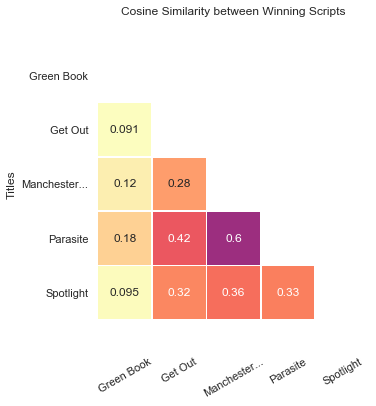

In [29]:
# Make similarity heatmap
# For winners
cmap = sns.color_palette('hls')
cmap = cmap.reverse()
sns.set(style = "white")
win_sim_df = pd.DataFrame(cosine_similarity(tfidf_winners_fit))
win_titles = ['Green Book', 'Get Out', 'Manchester...', 'Parasite', 'Spotlight']
win_sim_df['Titles'] = win_titles
#win_sim_df.set_index(['Titles'])
win_sim_df = win_sim_df.set_index(['Titles'])
Index = win_titles
win_sim_df = win_sim_df.rename(columns = {0: 'Green Book', 1: 'Get Out', 2: 'Manchester...', 3: 'Parasite', 4: 'Spotlight'})
win_sim_df
mask = np.triu(np.ones_like(win_sim, dtype=np.bool))
xticks = win_sim_df.columns
plt.figure(figsize = (9, 6))
ax = sns.heatmap(win_sim_df, cmap = "magma_r", annot = True,
            square = True, cbar = False,
            linewidth = 0.5, mask = mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(rotation = 30)
ax.set_yticklabels(
ax.get_yticklabels(), rotation = 0)
ax.set(title = "Cosine Similarity between Winning Scripts")
# ax.get_figure().savefig('./winnerheatmap.png')

[Text(0.5, 1, 'Cosine Similarity between Movie Genres')]

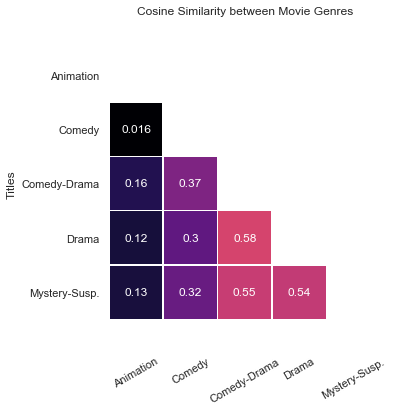

In [30]:
# By Genre

gen_sim_df = pd.DataFrame(cosine_similarity(tfidf_genre_fit))
gen_titles = ['Animation', 'Comedy', 'Comedy-Drama', 'Drama', 'Mystery-Susp.']
gen_sim_df["Titles"] = gen_titles
gen_sim_df = gen_sim_df.set_index(['Titles'])
gen_sim_df = gen_sim_df.rename(columns = {0: 'Animation', 1: 'Comedy', 
                                          2: 'Comedy-Drama', 3: 'Drama', 4: 'Mystery-Susp.'})

mask = np.triu(np.ones_like(gen_sim_df, dtype=np.bool))

xticks = gen_sim_df.columns

plt.figure(figsize = (9, 6))
ax = sns.heatmap(gen_sim_df, cmap = "magma", annot = True,
            square = True, cbar = False,
            linewidth = 0.5, mask = mask)
bottom, top = ax.get_ylim()
ax.set_yticklabels(
ax.get_yticklabels(), rotation = 0)
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(rotation = 30)
ax.set(title = "Cosine Similarity between Movie Genres")

# ax.get_figure().savefig('./genre_heatmap.png')

In [31]:
gen_sim_df

,Animation,Comedy,Comedy-Drama,Drama,Mystery-Susp.
Titles,,,,,
Animation,1.000000,0.015593,0.156630,0.123060,0.125826
Comedy,0.015593,1.000000,0.374127,0.300797,0.321481
Comedy-Drama,0.156630,0.374127,1.000000,0.584141,0.549367
Drama,0.123060,0.300797,0.584141,1.000000,0.537144
Mystery-Susp.,0.125826,0.321481,0.549367,0.537144,1.000000


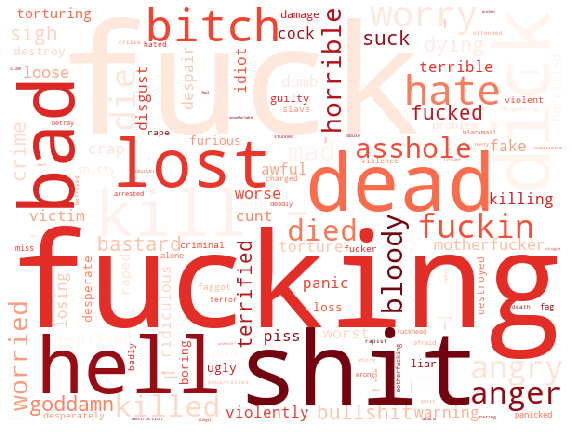

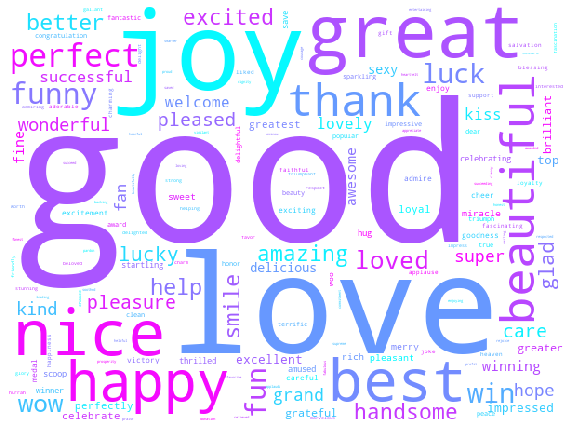

In [32]:
# Work for wordclouds

# Create tokenized words for all dialogue
movies_df['tokens'] = movies_df['cleaned_dialogue'].apply(word_tokenize)
movies_df

# make function to assign sentiment to tokenized words
def sentiment_score(words):
    sentiment_scores = [af.score(article) for article in words]
    return sentiment_scores

movies_df['senti'] = movies_df['tokens'].apply(sentiment_score)


# make df
tokens = movies_df['tokens']
senti = movies_df['senti']
tok = list(tokens)
sen = list(senti)

# Pairing and combining nested list to tuple list 
res = [(u, v) for x, y in zip(tok, sen) 
                               for u, v in zip(x, y)] 
res

# create dataframe from list of tuples
sent_df = pd.DataFrame(res, columns = ['word', 'senti'])

# get top 3500 positive and negative words for viz.
top3500_positive = sent_df.nlargest(3500, 'senti')
top3500_negative = sent_df.nsmallest(3500, 'senti')
top3500_negative = top3500_negative['word']
top3500_positive = top3500_positive['word']


# create string for word cloud
pos_str = ' '.join(top3500_positive)
negative_str = ' '.join(top3500_negative)
wc_negative = WordCloud(background_color = 'White', max_words = 200, 
               width = 600, height = 450, 
               collocations = False,
            colormap = 'Reds').generate(negative_str)

plt.figure(figsize = (10, 10))
plt.imshow(wc_negative)
#plt.title("Top Negative Sentiment Words")
plt.axis("off")

wc_positive = WordCloud(background_color = 'White', max_words = 200, 
               width = 600, height = 450, 
               collocations = False,
            colormap = 'cool').generate(pos_str)

plt.figure(figsize = (10, 10))
plt.imshow(wc_positive)
plt.axis("off")

wc_negative.to_file('./negative_sent.png')
wc_positive.to_file('./positive_sent.png')


## K Means Clustering  -- AR

CV does not produce good results, performed only on TFIDF

In [33]:
# define function to print terms of k clusters
def eval_k(kmeans, centroids, terms):
    cluster_terms = []
    for i in range(kmeans.n_clusters):
        termss = []
        for ind in centroids[i, :10]:
            termss.append(terms[ind])
        cluster_terms.append(termss)
    for i in range(kmeans.n_clusters):
        print(f'\tCluster {i+1}: {" ".join(cluster_terms[i])}')

### K Means Clustering -- Dialogue

	Cluster 1: dont thats youre los rose shes mike joy david power
	Cluster 2: gon beat lady charlie lip fucking god dick fuck bird


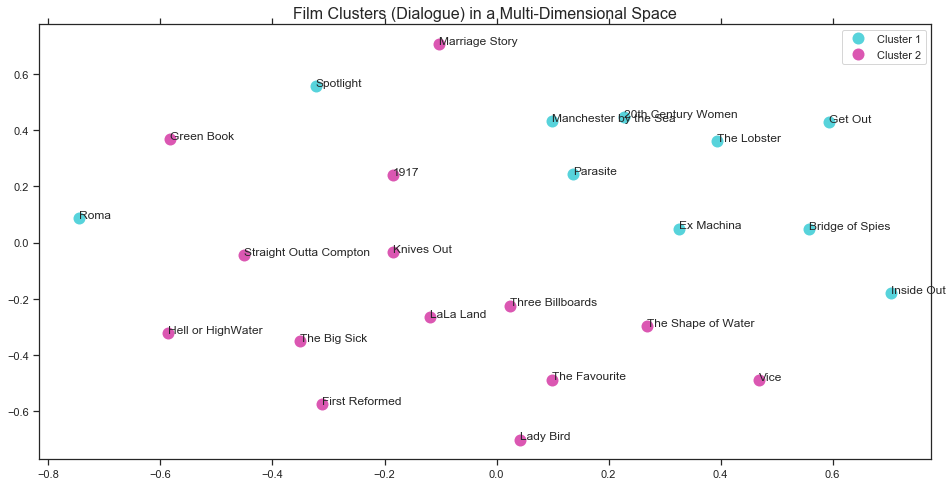

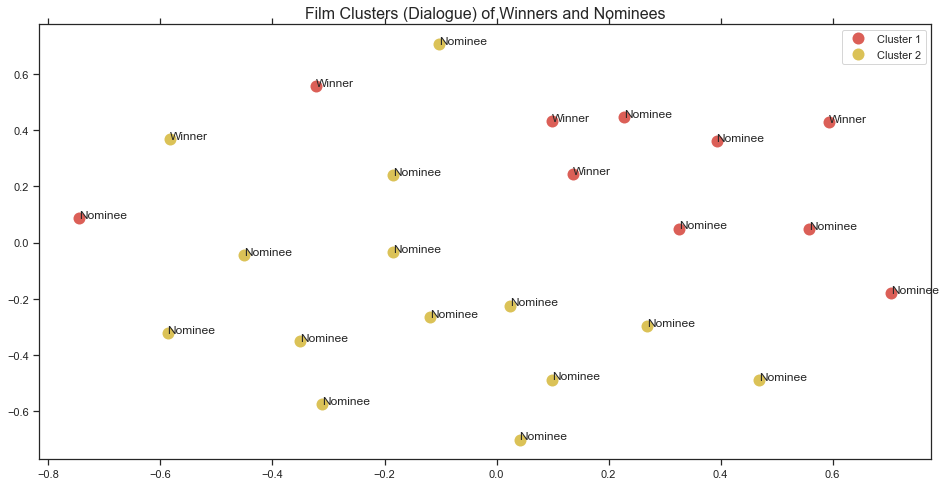

In [34]:
# collect feature names
feat_names_tf_d = tfidf_dialogue.get_feature_names()
# calculate cosine dist
dist_tf_d = 1 - cosine_similarity(tfidf_dialogue_fit)
# instantiate KMeans with 2 clusters (is there a separation between winners and losers?)
km_tf_d = KMeans(n_clusters = 2) 
# fit KMeans
km_tf_d.fit(tfidf_dialogue_fit)
# keep record of clusters and centroids
clusters_tf_d = km_tf_d.labels_.tolist()
centroids_tf_d = km_tf_d.cluster_centers_.argsort()[:, ::-1]
# add labels to df
movies_df['full_cluster'] = clusters_tf_d
# print terms for clusters
eval_k(km_tf_d, centroids_tf_d, feat_names_tf_d)

# project into multi-dim space for viz
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because provided a distance matrix (cosine)
# we will also specify `random_state` so the plot is reproducible.
mds_tf_d = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos_tf_d = mds_tf_d.fit_transform(dist_tf_d)  
xs_tf_d, ys_tf_d = pos_tf_d[:, 0], pos_tf_d[:, 1]

#create data frame that has the result of the MDS plus the cluster numbers and titles
df_tf_d = pd.DataFrame(dict(x=xs_tf_d, y=ys_tf_d, label=clusters_tf_d, title=list(movies_df['Title']))) 

#group by cluster
groups_tf_d = df_tf_d.groupby('label')

#set up colors per clusters using a dict
cluster_colors = {0: palette_list[4], 1: palette_list[7]}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 
                 1: 'Cluster 2'}

%matplotlib inline 
# set up plot
fig, ax = plt.subplots(figsize=(16, 8)) 
ax.margins(0.05) 

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups_tf_d:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df_tf_d)):
    ax.text(df_tf_d.iloc[i]['x'], df_tf_d.iloc[i]['y'], df_tf_d.iloc[i]['title'], size=12)  

plt.title("Film Clusters (Dialogue) in a Multi-Dimensional Space", size=16)

plt.show() 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df_tf_d = pd.DataFrame(dict(x=xs_tf_d, y=ys_tf_d, label=clusters_tf_d, winner=list(movies_df['orig_screen_win']), title=list(movies_df['Title']))) 
def label_win(text):
    if text == 0:
        text = "Nominee"
    else:
        text = "Winner"
    return text
df_tf_d['winner'] = df_tf_d['winner'].apply(lambda x: label_win(x))

#group by cluster
groups_tf_d = df_tf_d.groupby('label')

#set up colors per clusters using a dict
cluster_colors = {0: palette_list[0], 1: palette_list[1]}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 
                 1: 'Cluster 2'}

%matplotlib inline 
# set up plot
fig, ax = plt.subplots(figsize=(16, 8)) 
ax.margins(0.05) 

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups_tf_d:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df_tf_d)):
    ax.text(df_tf_d.iloc[i]['x'], df_tf_d.iloc[i]['y'], df_tf_d.iloc[i]['winner'], size=12)  

plt.title("Film Clusters (Dialogue) of Winners and Nominees", size=16)

plt.show() 

### K Means Clustering -- Full Script

	Cluster 1: cont lady lip continued bird apartment sofa richard los script
	Cluster 2: contd dont gon youre charlie thats david mike dick beth


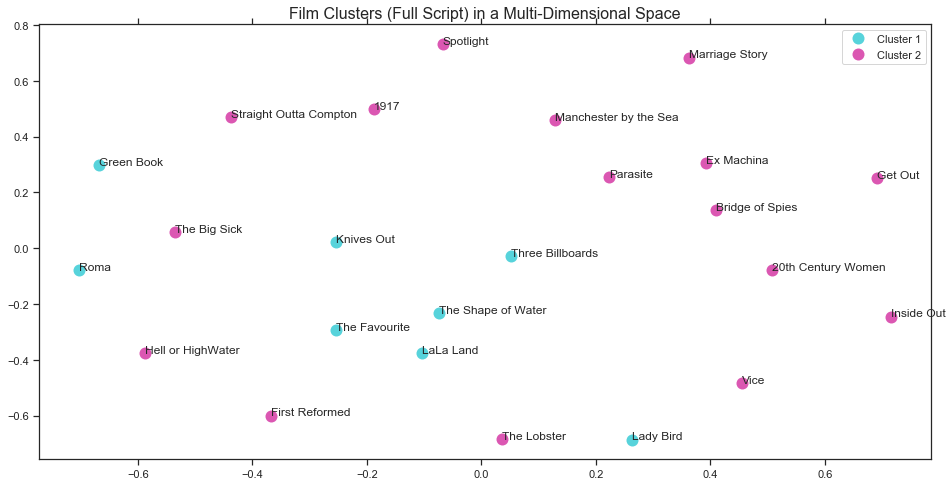

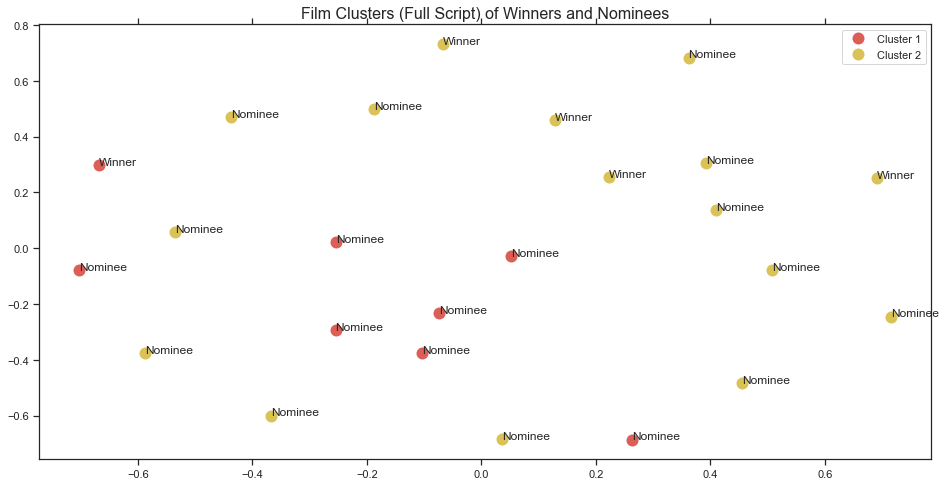

In [35]:
# collect feature names
feat_names_tf_a = tfidf_all.get_feature_names()
# calculate cosine dist
dist_tf_a = 1 - cosine_similarity(tfidf_all_fit)
# instantiate KMeans with 2 clusters (is there a separation between winners and losers?)
km_tf_a = KMeans(n_clusters = 2) 
# fit KMeans
km_tf_a.fit(tfidf_all_fit)
# keep record of clusters and centroids
clusters_tf_a = km_tf_a.labels_.tolist()
centroids_tf_a = km_tf_a.cluster_centers_.argsort()[:, ::-1]
# add labels to df
movies_df['full_cluster'] = clusters_tf_a
# print terms for clusters
eval_k(km_tf_a, centroids_tf_a, feat_names_tf_a)

# project into multi-dim space for viz
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because provided a distance matrix (cosine)
# we will also specify `random_state` so the plot is reproducible.
mds_tf_a = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos_tf_a = mds_tf_a.fit_transform(dist_tf_a)  
xs_tf_a, ys_tf_a = pos_tf_a[:, 0], pos_tf_a[:, 1]

#create data frame that has the result of the MDS plus the cluster numbers and titles
df_tf_a = pd.DataFrame(dict(x=xs_tf_a, y=ys_tf_a, label=clusters_tf_a, title=list(movies_df['Title']))) 

#group by cluster
groups_tf_a = df_tf_a.groupby('label')

#set up colors per clusters using a dict
cluster_colors = {0: palette_list[4], 1: palette_list[7]}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 
                 1: 'Cluster 2'}

%matplotlib inline 
# set up plot
fig, ax = plt.subplots(figsize=(16, 8)) 
ax.margins(0.05) 

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups_tf_a:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df_tf_a)):
    ax.text(df_tf_a.iloc[i]['x'], df_tf_a.iloc[i]['y'], df_tf_a.iloc[i]['title'], size=12)  

plt.title("Film Clusters (Full Script) in a Multi-Dimensional Space", size=16)

plt.show() 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df_tf_a = pd.DataFrame(dict(x=xs_tf_a, y=ys_tf_a, label=clusters_tf_a, winner=list(movies_df['orig_screen_win']), title=list(movies_df['Title']))) 
def label_win(text):
    if text == 0:
        text = "Nominee"
    else:
        text = "Winner"
    return text
df_tf_a['winner'] = df_tf_a['winner'].apply(lambda x: label_win(x))

#group by cluster
groups_tf_a = df_tf_a.groupby('label')

#set up colors per clusters using a dict
cluster_colors = {0: palette_list[0], 1: palette_list[1]}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 
                 1: 'Cluster 2'}

%matplotlib inline 
# set up plot
fig, ax = plt.subplots(figsize=(16, 8)) 
ax.margins(0.05) 

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups_tf_a:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df_tf_a)):
    ax.text(df_tf_a.iloc[i]['x'], df_tf_a.iloc[i]['y'], df_tf_a.iloc[i]['winner'], size=12)  

plt.title("Film Clusters (Full Script) of Winners and Nominees", size=16)

plt.show() 